The goal of this notebook is to try and numerically solve the following embedding problem. Suppose we have $k$ points and we know only their mutual distances. Can we isometrically embed these $k$ points in $\mathbb{R}^3$, and if not, what is the best possible approximate way of doing it?

In [45]:
import math
import numpy as np
import matplotlib.pyplot as plt

We define some functions for converting coordinates into distances, and distances into coordinates.

In [47]:
def to_distance_matrix(X):
    """We start with an N x d matrix X consisting of coordinates, 
    and convert it into an N x N matrix of Euclidean squared distances."""
    N = X.shape[0]
    d = X.shape[1]
    D = np.zeros((N, N), dtype = 'float')
    for i in range(0, N - 1):
        for j in range(i + 1, N):
            distance = 0
            for x in range(0, d):
                distance += (X[i][x] - X[j][x])**2 #We're not taking square roots.
            D[i][j] = distance
            D[j][i] = distance
    return D

def to_coordinate_matrix(D, output_dimension = 3, verbose = False):
    """We convert an N x N matrix of distances into an N x d matrix of coordinates."""
    d = output_dimension
    N = D.shape[0]
    N = N - 1 #The helper matrix is size N - 1
    if verbose:
      print("Computing the helper matrix...")
    helper_matrix = np.zeros((N, N), dtype = 'float')
    for i in range(0, N):
        for j in range(0, N):
            helper_matrix[i][j] = (D[i][N] - D[i][j] + D[j][N]) / 2
    if verbose:
      print("Running SVD...")
    U, S, VT = np.linalg.svd(helper_matrix) #Apply SVD
    if verbose:
      print("SVD complete. First five singular values:")
      print(S[0], S[1], S[2], S[3], S[4])
    S = np.diag(S) #Turn singular values into diagonal matrix
    X = U[:, 0:d] @ np.sqrt(S[0:d, 0:d]) #Note that we truncate to rank d
    #The coordinates of the last object must be taken to be zero
    Xtotal = np.zeros((N + 1, d))
    Xtotal[:-1, :] = X
    if verbose:
      print("Done!")
    return Xtotal

Let's generate a collection of random coordinates in $\mathbb{R}^3$, convert them to a distance matrix, and see if we can find them back again. 

In [51]:
N = 10 #number of points

with open('random_coordinates.csv', 'w') as f:
  for _ in range(N):
    r = np.random.rand(3)
    r_str = ','.join(str(x) for x in r)
    f.write(r_str + "\n")

In [53]:
X = np.genfromtxt('random_coordinates.csv', delimiter = ',')
print("Here is the initial coordinate matrix.")
print(X)
D = to_distance_matrix(X)
print("Now we compute their mutual squared distances.")
print(D)
Xnew = to_coordinate_matrix(D)
print("We infer what the coordinates were.")
print(Xnew)

Here is the initial coordinate matrix.
[[0.34266961 0.26495063 0.06679757]
 [0.71762831 0.76913645 0.36035376]
 [0.96857499 0.06617877 0.51202196]
 [0.50649096 0.44432115 0.82104593]
 [0.9322158  0.84374186 0.64854042]
 [0.49034788 0.77794334 0.5029993 ]
 [0.52917915 0.9352979  0.30756384]
 [0.1485782  0.39692517 0.73937915]
 [0.66156394 0.31961644 0.0597283 ]
 [0.43318903 0.99298902 0.25788102]]
Now we compute their mutual squared distances.
[[0.         0.48097259 0.62949256 0.6279018  1.02098874 0.47524233
  0.54211967 0.50745475 0.10473191 0.57474654]
 [0.48097259 0.         0.58012698 0.36232123 0.13466531 0.0720817
  0.06590949 0.60601951 0.29558712 0.14151634]
 [0.62949256 0.58012698 0.         0.45200912 0.62456363 0.73539138
  0.99023989 0.83347921 0.36305599 1.21020298]
 [0.6279018  0.36232123 0.45200912 0.         0.37053669 0.21271802
  0.50523677 0.13701739 0.61920342 0.62356431]
 [1.02098874 0.13466531 0.62456363 0.37053669 0.         0.22075893
  0.28708608 0.82198472 0.

We see that the coordinates are very different, so what happened? The answer is that the coordinates can only be recovered up to translation and rotation. To confirm that nothing went wrong, let's take the new coordinate matrix and apply the distance matrix function a second time.

In [43]:
Dnew = to_distance_matrix(Xnew)
print(Dnew)

[[0.         0.09107298 1.16784327 1.46203369 0.95883115 0.60676048
  0.55978448 0.7675026  0.26950095 0.43094137]
 [0.09107298 0.         0.81148803 0.87055058 0.55973087 0.24812003
  0.53516736 0.64262194 0.10302546 0.18248816]
 [1.16784327 0.81148803 0.         0.29885773 0.22617817 0.32523321
  0.76940009 0.15652591 0.59387628 0.98009387]
 [1.46203369 0.87055058 0.29885773 0.         0.15118726 0.21313495
  1.11494965 0.77911893 0.7076418  0.79658292]
 [0.95883115 0.55973087 0.22617817 0.15118726 0.         0.19957506
  0.45345026 0.50439992 0.58581386 0.79612803]
 [0.60676048 0.24812003 0.32523321 0.21313495 0.19957506 0.
  0.76253167 0.48156603 0.15017874 0.22252292]
 [0.55978448 0.53516736 0.76940009 1.11494965 0.45345026 0.76253167
  0.         0.62257613 0.85782067 1.25295675]
 [0.7675026  0.64262194 0.15652591 0.77911893 0.50439992 0.48156603
  0.62257613 0.         0.46776214 0.9533062 ]
 [0.26950095 0.10302546 0.59387628 0.7076418  0.58581386 0.15017874
  0.85782067 0.46776

Notice that $D$ and $D_{\mathrm{new}}$ produce the same output, just as we had hoped for.

Let's now try to something more exciting. We consider an embedding of the Klein bottle into $\mathbb{R}^4$, sample points from its surface, and see what it looks like when we try to find the closest-to-isometric dimmersion into $\mathbb{R}^3$. First, we gather our data.

In [46]:
N = 3600 #Number of data points. The algorithm runs at O(N^2), so make sure not to set N too large.
a = 3 #Parameters of the embeddings; make sure that a > b > 0
b = 2

N = math.floor(math.sqrt(N))
x = np.linspace(0, 2 * np.pi, N)
y = np.linspace(0, 2 * np.pi, N)
X, Y = np.meshgrid(x, y)
XY = np.array([X.flatten(),Y.flatten()]).T #A collection of N**2 coordinates in a unit square.

def embedding(xy):
    """We pick a nice explicit embedding of the Klein bottle in R4. 
    For coloring purposes we memorise the initial coordinates."""
    x = xy[0]
    y = xy[1]
    f1 = (b * np.cos(y) + a) * np.cos(x)
    f2 = (b * np.cos(y) + a) * np.sin(x)
    f3 = b * np.sin(y) * np.cos(x / 2)
    f4 = b * np.sin(y) * np.sin(y / 2)
    f = np.array([x, y, f1, f2, f3, f4])
    return f

Next, let's apply our SVD algorithm to find the best possible immersion of our data in $\mathbb{R}^3$.

In [35]:
coordinates = np.zeros((N**2, 6))
for i in range(N**2):
    coordinates[i] = embedding(XY[i])

X = coordinates[:, 2:6]
D = to_distance_matrix(X)
Xnew = to_coordinate_matrix(D)

Let's now plot our results and hope for the best.

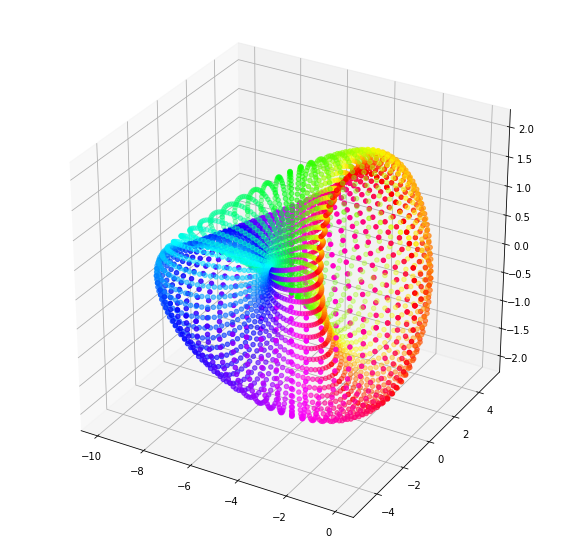

In [38]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection = '3d')
ax.scatter(Xnew[:, 0], Xnew[:, 1], Xnew[:, 2], c = coordinates[:, 0], cmap = 'hsv')
plt.show()